In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [84]:
# Load dataset
merged_df = pd.read_csv("../data/merged_dataset.csv")



C:\Users\hp\AppData\Local\Temp\ipykernel_16596\4277591185.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("../data/merged_dataset.csv")


In [85]:
# CPCB AQI Calculation using all major pollutants
def calculate_aqi(row):
    breakpoints = {
        'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400)],
        'co': [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
        'o3': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400)]
    }
    
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        if pollutant in row:
            value = row[pollutant]
            for c_low, c_high, i_low, i_high in bps:
                if c_low <= value <= c_high:
                    sub_index = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
                    sub_indices.append(sub_index)
                    break
    
    return max(sub_indices) if sub_indices else np.nan
# Apply AQI calculation to dataset
merged_df['AQI'] = merged_df.apply(calculate_aqi, axis=1)

In [86]:
# Feature Engineering
merged_df['rainfall'] = merged_df[[
    'JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']].sum(axis=1)
merged_df['rainfall_lag1'] = merged_df.groupby('location')['rainfall'].shift(1)
merged_df['monsoon_rain'] = merged_df[['JUN', 'JUL', 'AUG', 'SEP']].sum(axis=1)
merged_df['is_dry'] = (merged_df['JAN'] < 10).astype(int)



In [87]:
merged_df['rainfall_lag1'].fillna(merged_df['rainfall_lag1'].median(), inplace=True)
merged_df['sampling_date'] = pd.to_datetime(merged_df['sampling_date'], errors='coerce')
merged_df['day_of_week'] = merged_df['sampling_date'].dt.dayofweek
merged_df['week_of_year'] = merged_df['sampling_date'].dt.isocalendar().week

C:\Users\hp\AppData\Local\Temp\ipykernel_16596\4198798050.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['rainfall_lag1'].fillna(merged_df['rainfall_lag1'].median(), inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_16596\4198798050.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['sampling_date'] = pd.to_datetime(merged_df['sampling_date'], errors='coerce'

In [88]:
# Define features (X) and target (y)
features = ['year', 'month', 'rainfall', 'monsoon_rain', 'Latitude', 'Longitude', 
            'pm2_5', 'so2', 'no2', 'rspm', 'spm']  # Including all pollutants
X = merged_df[features]
y = merged_df['AQI']


In [89]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
y = y.fillna(y.median())


In [90]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [92]:
# Predictions
predictions = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"R²: {r2}")
print(f"RMSE: {rmse}")

R²: 0.9983231225610074
RMSE: 1.0060836131425293


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [93]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (348593, 11)
y_train shape: (348593,)
X_test shape: (87149, 11)
y_test shape: (87149,)


In [94]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
print(feature_importances.sort_values(by='Importance', ascending=False))


         Feature  Importance
8            no2    0.778829
6          pm2_5    0.175652
7            so2    0.043465
9           rspm    0.000690
0           year    0.000625
10           spm    0.000314
1          month    0.000242
2       rainfall    0.000059
3   monsoon_rain    0.000052
5      Longitude    0.000038
4       Latitude    0.000034


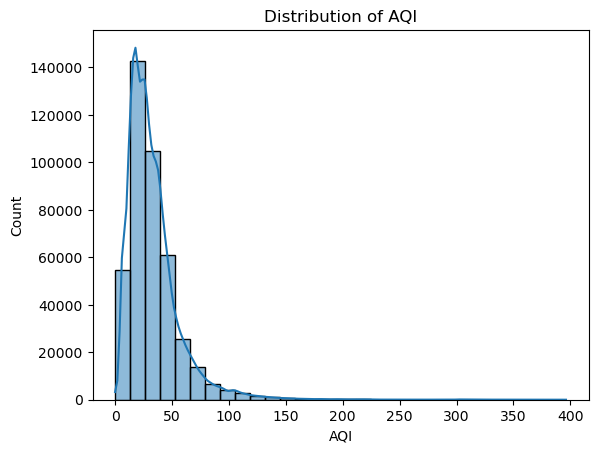

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(merged_df['AQI'], bins=30, kde=True)
plt.title("Distribution of AQI")
plt.show()


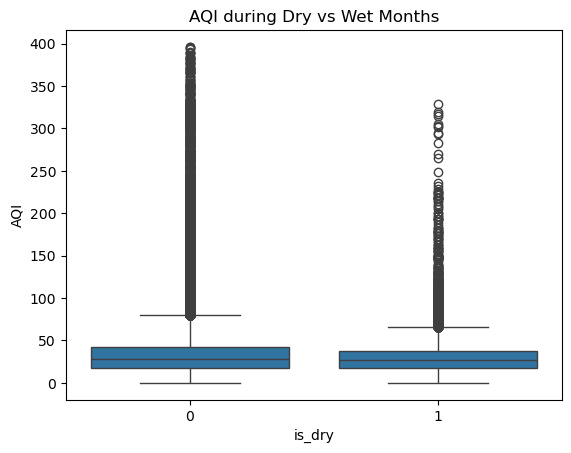

In [96]:
sns.boxplot(x=merged_df['is_dry'], y=merged_df['AQI'])
plt.title("AQI during Dry vs Wet Months")
plt.show()


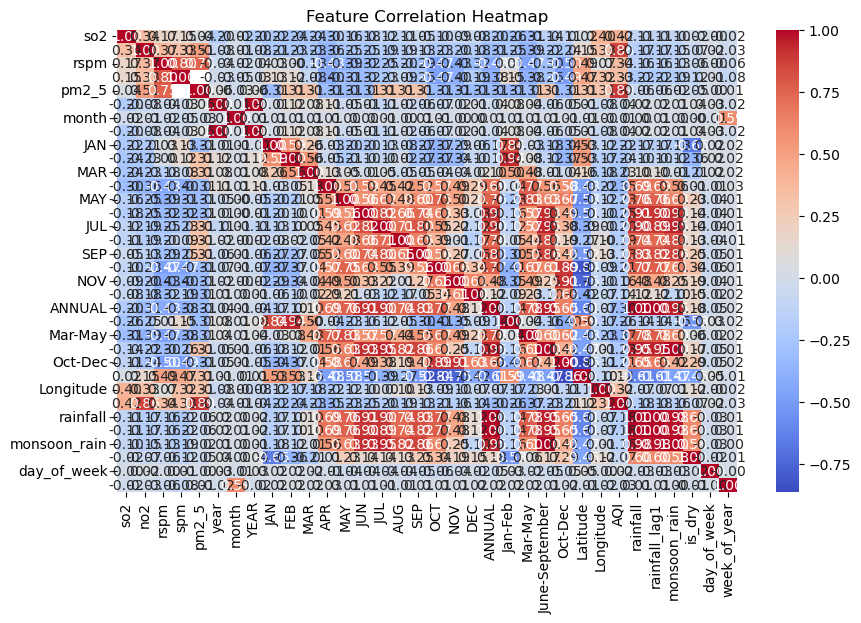

In [97]:
numeric_df = merged_df.select_dtypes(include=['number'])  # Keep only numeric columns
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



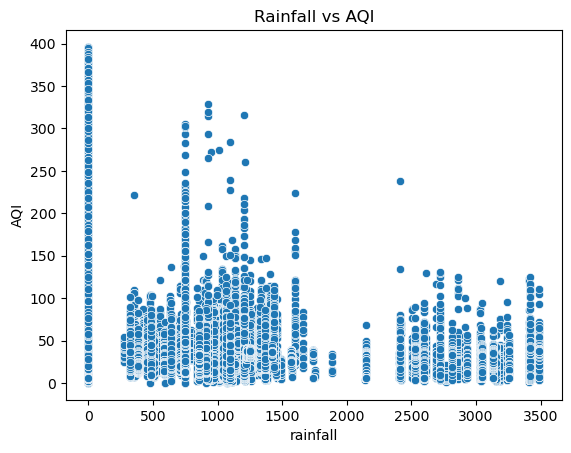

In [98]:
sns.scatterplot(x=merged_df['rainfall'], y=merged_df['AQI'])
plt.title("Rainfall vs AQI")
plt.show()


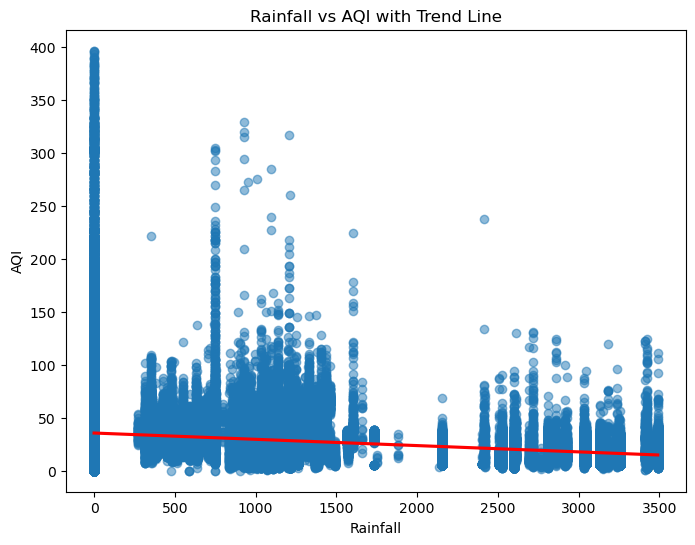

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'rainfall' and 'AQI' columns
plt.figure(figsize=(8, 6))
sns.regplot(x=merged_df["rainfall"], y=merged_df["AQI"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Rainfall vs AQI with Trend Line")
plt.xlabel("Rainfall")
plt.ylabel("AQI")
plt.show()


In [100]:
import numpy as np

correlation = np.corrcoef(merged_df["rainfall"], merged_df["AQI"])[0, 1]
print(f"Pearson correlation: {correlation:.3f}")


Pearson correlation: nan


In [101]:
print(merged_df["rainfall"].nunique(), merged_df["AQI"].nunique())  


182 7659


In [102]:
print(merged_df.isna().sum())  # Count missing values
print(merged_df[merged_df.isin([np.inf, -np.inf])].count())  # Count infinite values


stn_code                       144077
sampling_date                   23047
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
year                                7
month                               7
YEAR                                7
JAN                            318495
FEB                            318495
MAR                            318495
APR                            318495
MAY                            318495
JUN                            318495
JUL                            318495
AUG                            318495
SEP                            318495
OCT                            318495
NOV         

In [103]:
threshold = 0.5  # Set threshold for missing data removal
merged_df = merged_df[merged_df.columns[merged_df.isnull().mean() < threshold]]
print("Remaining columns after dropping high-missing columns:", merged_df.columns)


Remaining columns after dropping high-missing columns: Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'location_monitoring_station', 'date', 'year',
       'month', 'YEAR', 'AQI', 'rainfall', 'rainfall_lag1', 'monsoon_rain',
       'is_dry', 'day_of_week', 'week_of_year'],
      dtype='object')


In [104]:
merged_df.fillna(method="ffill", inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_16596\2605498804.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method="ffill", inplace=True)


In [105]:
correlation = merged_df["rainfall"].corr(merged_df["AQI"])
print(f"Pearson correlation after cleaning: {correlation:.3f}")


Pearson correlation after cleaning: -0.181


In [106]:
spearman_corr = merged_df["rainfall"].corr(merged_df["AQI"], method="spearman")
print(f"Spearman correlation: {spearman_corr:.3f}")


Spearman correlation: -0.161
